### WaveNet

In This lecture, we will be improving the performance of the model even further by implementing WaveNet architecture. While original purpose of this architecture is for Raw Audio, it can bring improvements to tasks where patterns over long sequences need to be learnt. 

In essence, WaveNet allows us to efficiently learn from longer sequences of input data due to its use of dilated causal convolutions, which expand the model's receptive field without a corresponding increase in computational complexity. This capability enables the model to capture and generate detailed and nuanced patterns that are essential for producing high-quality, realistic sequences, making it suitable for a variety of applications beyond audio, such as weather forecasting, financial time series prediction, and more.

So the 3 Key features of the architecture are as follows: 
1) Dilated Convolution
    * Dilated convolution is a technique where the convolutional kernel is applied over an area larger than its actual size by skipping input values at a regular interval. This is controlled by the dilation rate, which dictates the spacing between the points in the data that the filter covers.
        * Consider a 1-dimensional sequence of audio samples. Using a dilated convolution with a dilation rate of 2 and a kernel size of 3, the convolutional filter would cover elements at positions [1, 3, 5] instead of [1, 2, 3]. This effectively allows the filter to 'see' more data without increasing the kernel size.
    * This approach enables the model to have a wider receptive field, allowing it to capture long-range dependencies in the data without significantly increasing computational complexity or the number of parameters. This is particularly useful in processing audio, where understanding context from a larger sequence is crucial for generating coherent sounds.
2) Causal Convolutions
    * Causal convolutions ensure that the output at any point is only dependent on past and present inputs, not future inputs. This is achieved by padding the input sequence on the left (for time series data) and not on the right, aligning the output with the input in such a way that it only depends on what has come before it.
        * In a speech generation model, when predicting the next audio sample at time t, a causal convolution would use only the samples from time t−1, t−2, etc., ensuring that the generation process is temporally coherent and realistic.
    * Causal convolutions are useful for any generative model where the sequence must be generated in a forward direction, as in speech or music. This ensures that the model does not cheat by using future information, thereby making the model suitable for real-time applications.
3) Autoregressive Models
    * In autoregressive models, each output is predicted based on previous outputs. The model regresses on its own outputs, using past values to predict future values in a sequence.
        * In WaveNet, each new audio sample is generated based on all previously generated samples. For example, to generate the next sound in a speech sequence, the model looks at the previously generated sounds and computes the most likely next sound based on that history.
    * Autoregressive modeling allows for detailed and nuanced control over the generation process, as each step in the sequence can refine the prediction based on the accumulated context. This is crucial for producing high-quality, realistic audio sequences where each sound is a continuation of what was previously heard.

The Flattening Scheme that we are going to use is shown in the Figure below: 
<center><img src="./images_WaveNet/WaveNet.png" width="600" alt="Example" /></center>

Additionally the original paper can be found here: https://arxiv.org/pdf/1609.03499

#### Plan for the lecture

##### Part 0 - Review

0) importing the code from previous lectures

##### Part 1 - Fixing up the code, to make it more respectable and PyTorch compliant

0) Forward Pass 
1) Lack of structure when defining a neural network, a very "Naked" List

##### Part 2 - Incorporating The WaveNet Architecture

0) Reworking the flattening layer
1) Reworking the BatchNorm as a bug will appear due to change in structure



In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

Part 0 - Review

In [4]:
words = open("./names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# Creating the Dataset

import random
block_size = 3

def build_dataset(words):

    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':

            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# Showcasing Input/Output relationships created in datasets

for x, y in zip(Xtr[:14], Ytr[:14]):
    print("".join(itos[ix.item()] for ix in x), "---->", itos[y.item()])

... ----> y
..y ----> u
.yu ----> h
yuh ----> e
uhe ----> n
hen ----> g
eng ----> .
... ----> d
..d ----> i
.di ----> o
dio ----> n
ion ----> d
ond ----> r
ndr ----> e
dre ----> .


In [8]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim=True)
            # batch variance
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [9]:
torch.manual_seed(42)

In [12]:
# Constructing the Neural Network with our Layers as building blocks 
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for l in layers for p in l.parameters()]
print(f"num parameters: {sum(p.numel() for p in parameters)}")

for p in parameters:
    p.requires_grad_()

num parameters: 12097


In [13]:
# Training part
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]  # embed characters into vector space
    x = emb.view((emb.shape[0], -1))  # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())
    break

step 0 loss 3.313666343688965


##### Part 1 - Fixing up the code, to make it more respectable and PyTorch compliant

1) implementing classes "Embedding" and "Flatten" we make the code less gnarly to look at and understand.
2) implementing class "Sequential" we give the naked list some needed structure. 

In [14]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim=True)
            # batch variance
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# ---------------- new ----------------


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]


class Flatten:
    def __call__(self, x):
        self.out = x.view((x.shape[0], -1))
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

now we can observe how much cleaner this allows our code to be 

In [15]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),

    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 12097


In [ ]:
# Training
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass is now simpler
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())

    break

In [16]:
# Evaluating the model 

for layer in model.layers:
    layer.training = False
    
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "valid": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()


print("train", split_loss("train"))
print("valid", split_loss("valid"))

train 3.5926153659820557
valid 3.591214656829834


In [17]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)

    print("".join(itos[i] for i in out))

oznwarqscznyamf
gvacyovflqeqrhtnnufiprammkjaxvizntzvzhp
ousrxxlpplrrqvhzixwpyzryhtmpuifgnspy
u
boomkjnrkmxprzpcwbzfqrmvnkkhixyyd
qeukluadtnzd
gajwpyme
e
i
s
negyyncwawjyizzajwsmqdnvixqraqpqkuihopyfxhsxvynevvxxozvhqincyyow
ujabmpzrbdfvvxzivxscjcrnxutpy
snatmedhfvhczfxycpvgocnehgulwfyasgakbbfsuitajcyrokfdpeymlniqkfmhrukhkrkfpplakeikriipcighaskfqitszavhwaozdmaywhe
uutkqursuznrunqjpyzvdqjzedeyeocjwjktjnhxxuzmt
vp
l

vnkwmeidvrnwbibmookbedxnrkhdgzmkwzhugas
smayqcjwgmkzfnwwmkfwdfebmljxqeptfffnmfpdhetdwdajfftdhstkjpz
nj


##### Part 2 - Incorporating WaveNet Architecture

<center><img src="./images_WaveNet/WaveNet.png" width="600" alt="Example" /></center>

We will be changing the 'block_size' to 8 from 3, in order to better understand the benefits of wavenet on longer sequences. 


In [18]:
import random
block_size = 8


def build_dataset(words):

    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':

            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

for x, y in zip(Xtr[:15], Ytr[:15]):
    print("".join(itos[ix.item()] for ix in x), "---->", itos[y.item()])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])
........ ----> e
.......e ----> b
......eb ----> r
.....ebr ----> i
....ebri ----> m
...ebrim ----> a
..ebrima ----> .
........ ----> h
.......h ----> i
......hi ----> l
.....hil ----> t
....hilt ----> o
...hilto ----> n
..hilton ----> .
........ ----> j


initializing the network, without architectural changes

In [19]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),

    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 22097


In [20]:
# batch of 4 examples, each containing 8 numbers that denote the characters, Those 8 characters are part of the Input in the I/O pairs of the training dataset. 
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  1,  6,  6,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 25,  9,  1, 14]])

In [21]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {layer.out.shape}")

Embedding has output size of: torch.Size([4, 8, 10])
Flatten has output size of: torch.Size([4, 80])
Linear has output size of: torch.Size([4, 200])
BatchNorm1d has output size of: torch.Size([4, 200])
Tanh has output size of: torch.Size([4, 200])
Linear has output size of: torch.Size([4, 27])


Embedding Layer has the output in the shape of [4, 8, 10], because every one of the 8 characters passed in is transformed into a 10 dimensional vector. After this the flattening layer flattens all 8 characters into 1 long vector, causing the final shape to be [4, 80]. 

Current set up with the flattening layer means that we process 8 characters at the same time, which is not our goal according to the figure. Rather, our goal is to process them in X groups of 2 characters, until we converge to 1 group of 2 characters for our final output. 

so in the first layer instead of processing 

1 2 3 4 5 6 7 8

we will process 

(1 2) (3 4) (5 6) (7 8)

in essence this means that instead of multiplying (4, 80) @ (80, 200) = (4, 200), we multiply (4, 4, 20) @ (80, 200) = (4, 4, 200). 

In [25]:
# There are several ways we can achieve the shape of input that we seek, both explicit and implicit.

# output of layer 0
e = torch.randn(4, 8, 10)
# contacenate even and odd (on character dimension) elements of the last dimension
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
# you can do the same using view
implicit = e.view(4, 4, 20)

(implicit == explicit).all()

tensor(True)

So, we reimplement the flattening layer

In [24]:
# Reimplement Flatten
class FlattenConsecutive:
    def __init__(self, n):
        # n is the number of consecutive elements we want (2 in our example)
        self.n = n

    def __call__(self, x):
        # in our example: B = 4, T = 8, C = 10
        B, T, C = x.shape
        # we want to convert X to (4, 4, 20)
        x = x.view(B, T // self.n, C * self.n)

        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out

    def parameters(self):
        return []

In [26]:
n_embd = 10
# changing the number of hidden units to 68 keeps the same number of parameters as the previous model (22k)
n_hidden = 68

# if we were to initialize FlattenConsecutive(block_size), it will still go ahead and flatten the entire input into one long vector
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 22097


In [31]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]

logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 10,  1],
        [ 0,  0,  0, 18,  1, 25, 12, 25],
        [ 0,  0,  5, 12, 14, 15, 18,  1],
        [ 0,  0,  0,  0,  0, 26,  1,  5]])

In [32]:
for layer in model.layers:
    print(f"{layer.__class__.__name__} has output size of: {layer.out.shape}")

Embedding has output size of: torch.Size([4, 8, 10])
FlattenConsecutive has output size of: torch.Size([4, 80])
Linear has output size of: torch.Size([4, 200])
BatchNorm1d has output size of: torch.Size([4, 200])
Tanh has output size of: torch.Size([4, 200])
Linear has output size of: torch.Size([4, 27])


Finally, we have a bug that needs to be addressed with BatchNormalization

The bug is due to the fact that our batchnormalization was written for 2 dimensional input only, as soon as 3 dimensional input enters, you may expect suboptimal performance. The Mean and Variance in previous implemention is calculated for first dimension only, we want to calculate it over the 2nd dimension as well. 

In [33]:
e = torch.rand(32, 4, 68)
emean = e.mean(dim=(0, 1), keepdim=True)  # (1, 1, 68)
evar = e.var((0, 1), keepdim=True)  # (1, 1, 68)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)

print(ehat.shape)
print(f"shape of running mean is {model.layers[3].running_mean.shape}")

torch.Size([32, 4, 68])
shape of running mean is torch.Size([1, 200])


In [34]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # determine the dimension to reduce over
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)

            xmean = x.mean(dim, keepdim=True)
            # batch variance
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [35]:
n_embd = 10
# changing the number of hidden units to 68 keeps the same number of parameters as the previous model (22k)
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(f"num parameters: {sum(p.numel() for p in parameters)}")
for p in parameters:
    p.requires_grad_()

num parameters: 22397


##### Let's Summarize our progress

In [36]:
# Layers made in part 3
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # determine the dimension to reduce over
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)

            xmean = x.mean(dim, keepdim=True)
            # batch variance
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]


class Flatten:
    def __call__(self, x):
        self.out = x.view((x.shape[0], -1))
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


class FlattenConsecutive:
    def __init__(self, n):
        # n is the number of consecutive elements we want (2 in our example)
        self.n = n

    def __call__(self, x):
        # in our example: B = 4, T = 8, C = 10
        B, T, C = x.shape
        # we want to convert X to (4, 4, 20)
        x = x.view(B, T // self.n, C * self.n)

        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out

    def parameters(self):
        return []

In [37]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden,
                                  bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [38]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3122
  10000/ 200000: 1.8999
  20000/ 200000: 2.1902
  30000/ 200000: 1.8471
  40000/ 200000: 2.3311
  50000/ 200000: 2.2637
  60000/ 200000: 2.1406
  70000/ 200000: 2.0446
  80000/ 200000: 2.0532
  90000/ 200000: 2.0178
 100000/ 200000: 1.6284
 110000/ 200000: 1.8973
 120000/ 200000: 1.8976
 130000/ 200000: 2.0712
 140000/ 200000: 1.9213
 150000/ 200000: 1.7763
 160000/ 200000: 1.9869
 170000/ 200000: 1.8898
 180000/ 200000: 1.5488
 190000/ 200000: 1.4480


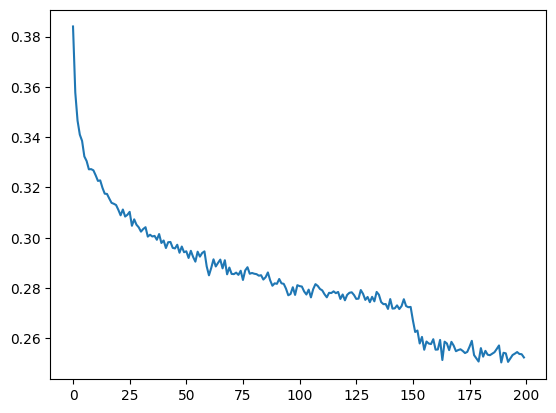

In [39]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1, keepdim=True).data)


In [40]:
for layer in model.layers:
    layer.training = False
    
print("train", split_loss("train"))
print("valid", split_loss("valid"))

train 1.7672295570373535
valid 1.9881629943847656


In [41]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        logits = model(torch.tensor([context]).reshape(1, -1))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)

    print("".join(itos[i] for i in out))

nogha
lowing
arcansour
noaly
milena
deleann
lindsha
spenan
elyash
autumn
roccael
brexel
manuello
horatin
miazi
alanova
mel
johnce
mikjoh
ryon
